<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import math
import itertools
from matplotlib import rcParams
from scipy import integrate
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Pharmacokinetics model
Paper: 

AI-Aristotle: A physics-informed framework for systems biology gray-box identification

$$
k_g = k_0t^{-\lambda}
$$
$$
\dot{B} = k_gG-k_bB
$$

$$
\dot{G} = -k_gG
$$


$$
\dot{U} = k_bB
$$

$$
parameters : k_0, k_b, \lambda
$$


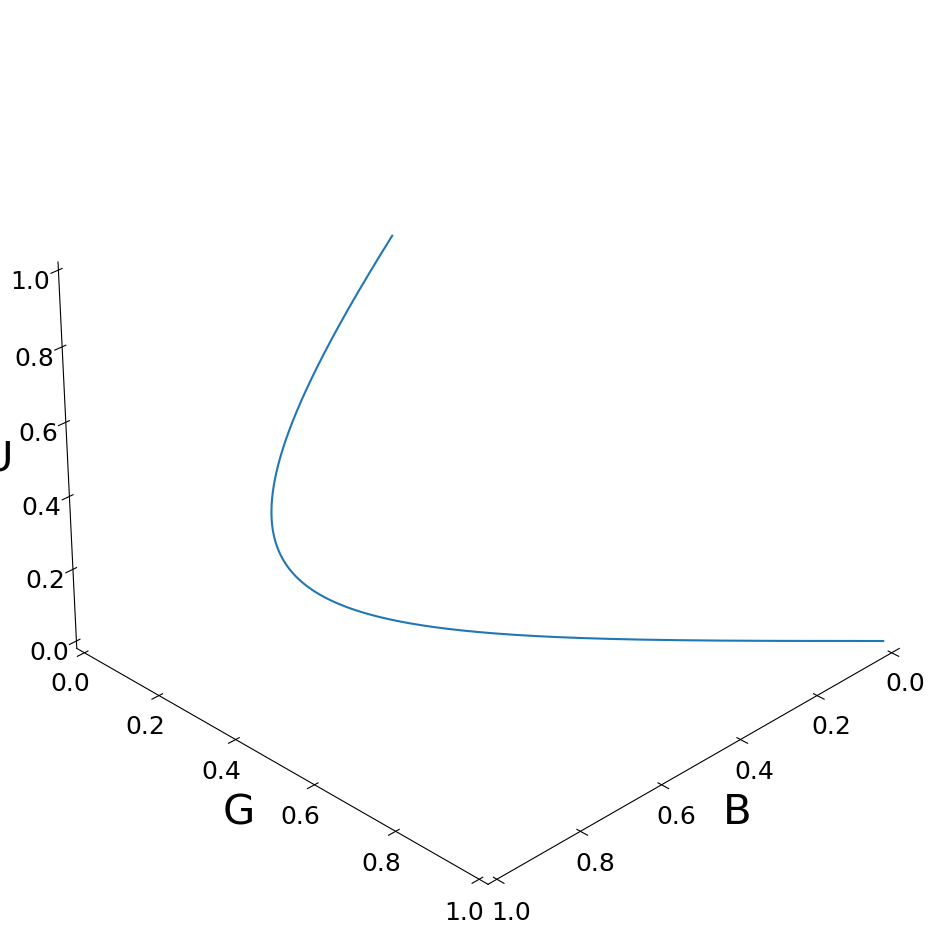

In [2]:
dt = 0.001
T  = 10
t  = np.arange(1e-3,T+dt,dt)

k0 = 0.72
kb = 0.15
lam = 0.5

def deriv(X, t0, k0, kb, lam):
    B, G, U = X
    kg = k0 * np.power(t0, -1*lam)
    dBdt = kg * G - kb*B
    dGdt = -kg * G
    dUdt = kb*B
    return [dBdt, dGdt, dUdt]

# Initial conditions
X0 = [0.0, 1.0, 0.0]



# Integrate the equations
X = odeint(deriv, X0, t, args=(k0, kb, lam))

# Extract the results
B = X[:, 0]
G = X[:, 1]
U = X[:, 2]


x=B
y=G
z=U

# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plotting the data
ax.plot(x[t<=10], y[t<=10], z[t<=10])

# Setting labels with Times New Roman font
ax.set_xlabel("B", labelpad=8, fontsize = 30)
ax.set_ylabel("G", labelpad=8, fontsize = 30)
ax.set_zlabel("U", labelpad=8, fontsize = 30)

# Set limits for x and y axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('3d_plot.pdf', format='pdf', bbox_inches='tight')

# Display plot
plt.show()

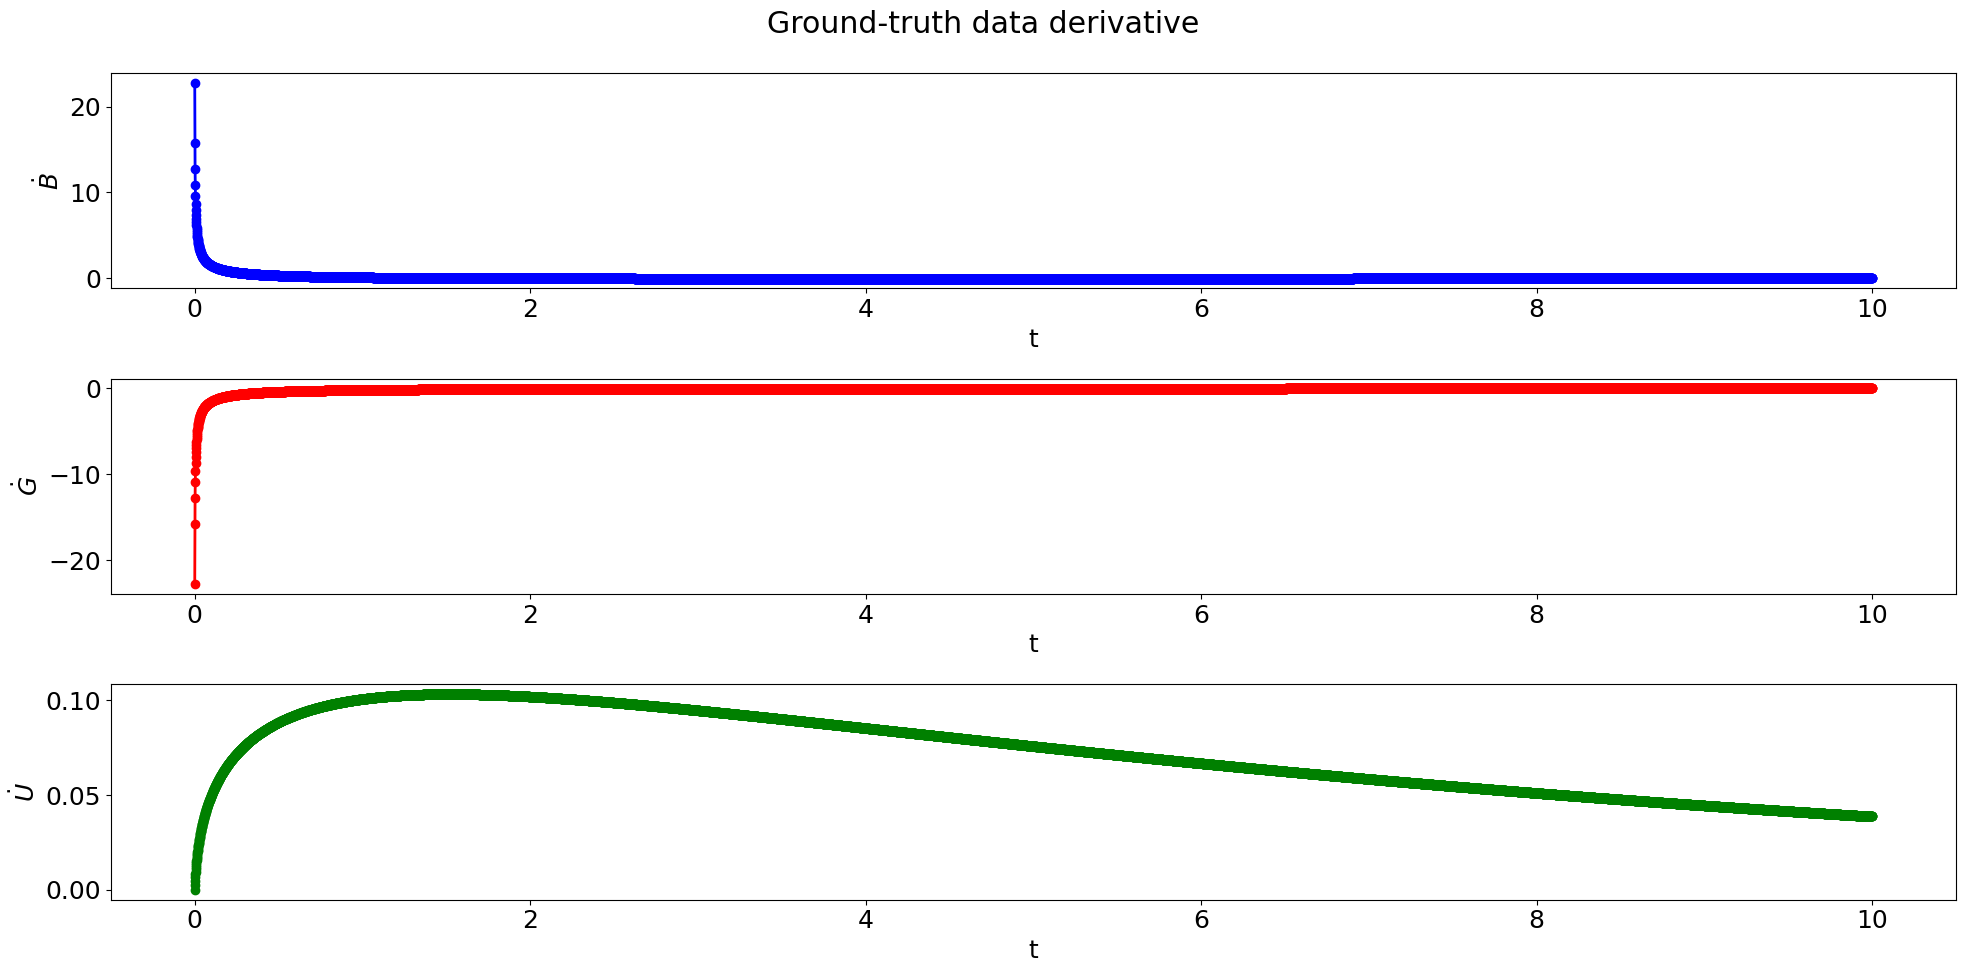

In [3]:
def DERIVATIVE(B, G , U, k0, kb, lam):
    kg = k0 * np.power(t, -1*lam)
    dBdt = kg * G - kb*B
    dGdt = -kg * G
    dUdt = kb*B
    return np.vstack((dBdt, dGdt, dUdt)).T

A1A2A3_time_deriv = DERIVATIVE (B, G, U, k0, kb, lam)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
fig.suptitle('Ground-truth data derivative')

# Plot dS/dt
ax[0].plot(t, A1A2A3_time_deriv[:, 0], '-o', color='blue', linewidth=2)
ax[0].set(xlabel="t", ylabel=r"$\dot{B}$")

# Plot dI/dt
ax[1].plot(t, A1A2A3_time_deriv[:, 1], '-o', color='red', linewidth=2)
ax[1].set(xlabel="t", ylabel=r"$\dot{G}$")

# Plot dR/dt
ax[2].plot(t, A1A2A3_time_deriv[:, 2], '-o', color='green', linewidth=2)
ax[2].set(xlabel="t", ylabel=r"$\dot{U}$")

fig.tight_layout()
plt.show()

In [4]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    yout[:,0] = np.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)

    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [5]:
nums = [1.0]              #numbers in the denominator [ sin(pi/a)]
sin_freq = np.pi / np.array(nums)     #frequencies for sin and cos function

modes = [ 0.45, 0.55]
x_t = X

def generate_candidates(x_t, t, sin_freq, modes):
    """
    Generates polynomial, sine, cosine, and exponential terms, and their combinations
    based on input data. Handles cases where x_t has dimensions (1000, 2) or (1, 2).
    
    Parameters:
    x_t : array-like of shape (N, 3)
        Input data for N data points with three variables (x and y and z).
    sin_freq : list of float
        Frequencies for sine and cosine functions.
    x_exp_powers : list of float
        Coefficients for the exponential of x (exp(a*x)).
    y_exp_powers : list of float
        Coefficients for the exponential of y (exp(a*y)).
    z_exp_powers : list of float
        Coefficients for the exponential of z (exp(a*z)).
    
    Returns:
    All_candidates : array-like
        Combined matrix of polynomial, sine, cosine, and exponential terms.
    """
    
    # Extract x and y from x_t
    x = x_t[:, 0]  # First column is x
    y = x_t[:, 1]  # Second column is y
    z = x_t[:, 2]  # third column is z
    
    # Polynomial terms (modify poolData if needed to handle both shapes)
    polynomial = poolData(x_t, 3, 1)
    poly_candidate = polynomial[:, 1:]
    
    N_sin_freq = len(sin_freq)
    
    # Fourier terms
    Nsize = poly_candidate.shape[1] * N_sin_freq
    sine_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    cos_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    
    k = 0
    for i in range(poly_candidate.shape[1]):
        for j in range(N_sin_freq):
            sine_candidate[:, k] = np.sin(poly_candidate[:, i] * sin_freq[j])
            cos_candidate[:, k] = np.cos(poly_candidate[:, i] * sin_freq[j])
            k += 1
    
    # Fourier terms * polynomial terms
    xsine_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    xcos_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    
    k = 0
    for i in range(Nsize):
        for j in range(poly_candidate.shape[1]):
            xsine_candidate[:, k] = sine_candidate[:, i] * poly_candidate[:, j]
            xcos_candidate[:, k] = cos_candidate[:, i] * poly_candidate[:, j]
            k += 1

    
    t_powers = np.column_stack([t**(-mode) for mode in modes])
    
    def multiply_poly_tpowers(poly_candidate, t_powers):
    
        result = np.empty((poly_candidate.shape[0], 0))
    
        for i in range(poly_candidate.shape[1]):
        
            for j in range(t_powers.shape[1]):
            
                new_column = poly_candidate[:, i].reshape(-1, 1) * t_powers[:, j].reshape(-1, 1)
            
                result = np.hstack((result, new_column))
    
        return result

    combined_terms = multiply_poly_tpowers(poly_candidate, t_powers)
    
    # Combine all candidate terms
    All_candidates = np.hstack((polynomial, sine_candidate, cos_candidate, xsine_candidate, xcos_candidate, combined_terms))
    
    return All_candidates




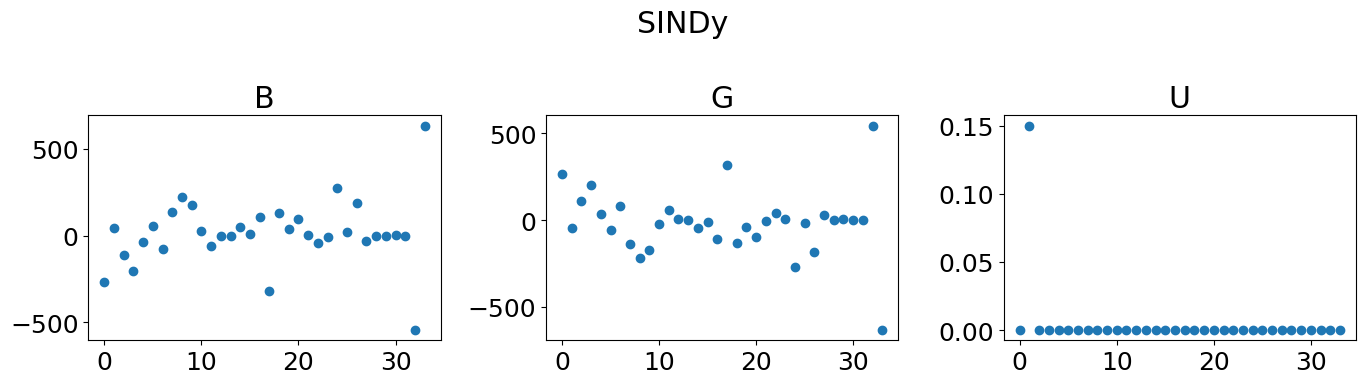

[[-267.5186936516113     44.27707442639203  -109.88226488076813
  -201.9111813914604    -37.18781736567632    57.539357794340816
   -78.32103698495051   138.46803024045212   220.02891403690285
   174.63424581066067    23.64311190294111   -57.6951952663969
    -3.137493687535599   46.67560548671723    10.552500363555431
   106.47770770417588  -317.5906007174246    132.78948031861276
    38.2473105044608     97.17159081028045     3.051367579899393
   -42.58191359878823    -8.690590144127485  271.30127967753265
    19.769520668260338  186.6014029496342    -31.735981505315664
    -0.761423106691154   -4.335381007158167    0.653605825394223
  -544.4174864597916    633.9335439896614  ]]
[[ 267.4811938426575    -44.389574476466265  109.91976501040442
   201.94868146643324    37.187817409124406  -57.53935785598829
    78.32103701743915  -138.46803031591665  -220.02891415525983
  -174.63424593016796   -23.643111912819897   57.6951953159507
     3.137493689586002  -46.67560551748344   -10.552500

In [6]:
Candidates = generate_candidates (x_t,t, sin_freq=sin_freq, modes =modes )

lamb = 0.1 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(Candidates, A1A2A3_time_deriv, lamb, 3)
#coeff_matrix = sparsifyDynamics(All_candidates, A1A2A3_time_deriv_sliced, lamb, 3)
#print(coeff_matrix)
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o') 
ax[0].set_title('B')


ax[1].plot(coeff_matrix [:, 1], 'o') 
ax[1].set_title('G')


ax[2].plot(coeff_matrix [:, 2], 'o') 
ax[2].set_title('U')


fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[np.nonzero(coeff_matrix[:, 0]), 0])
print(coeff_matrix[np.nonzero(coeff_matrix[:, 1]), 1])
print(coeff_matrix[np.nonzero(coeff_matrix[:, 2]), 2])
print(np.nonzero(coeff_matrix[:, 0]))
print(np.nonzero(coeff_matrix[:, 1]))
print(np.nonzero(coeff_matrix[:, 2]))

In [7]:
print(coeff_matrix[:, 0])
print(coeff_matrix[:, 1])
print(coeff_matrix[:, 2])

[-267.5186936516113     44.27707442639203  -109.88226488076813
 -201.9111813914604    -37.18781736567632    57.539357794340816
  -78.32103698495051   138.46803024045212   220.02891403690285
  174.63424581066067    23.64311190294111   -57.6951952663969
   -3.137493687535599    0.                  46.67560548671723
   10.552500363555431  106.47770770417588  -317.5906007174246
  132.78948031861276    38.2473105044608     97.17159081028045
    3.051367579899393  -42.58191359878823    -8.690590144127485
  271.30127967753265    19.769520668260338  186.6014029496342
  -31.735981505315664   -0.761423106691154   -4.335381007158167
    0.653605825394223    0.                -544.4174864597916
  633.9335439896614  ]
[ 267.4811938426575    -44.389574476466265  109.91976501040442
  201.94868146643324    37.187817409124406  -57.53935785598829
   78.32103701743915  -138.46803031591665  -220.02891415525983
 -174.63424593016796   -23.643111912819897   57.6951953159507
    3.137493689586002    0.       

In [8]:
def SINDy_oscillator_deriv(x_y, t):
    out = generate_candidates (np.array(x_y)[np.newaxis, :], t, sin_freq=sin_freq, modes=modes)@coeff_matrix
    return np.squeeze(out).tolist()

np.random.seed(123)
x0 = (0.0, 1.0, 0.0)
x1_t = integrate.odeint(SINDy_oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x1, y1, z1 = x1_t.T

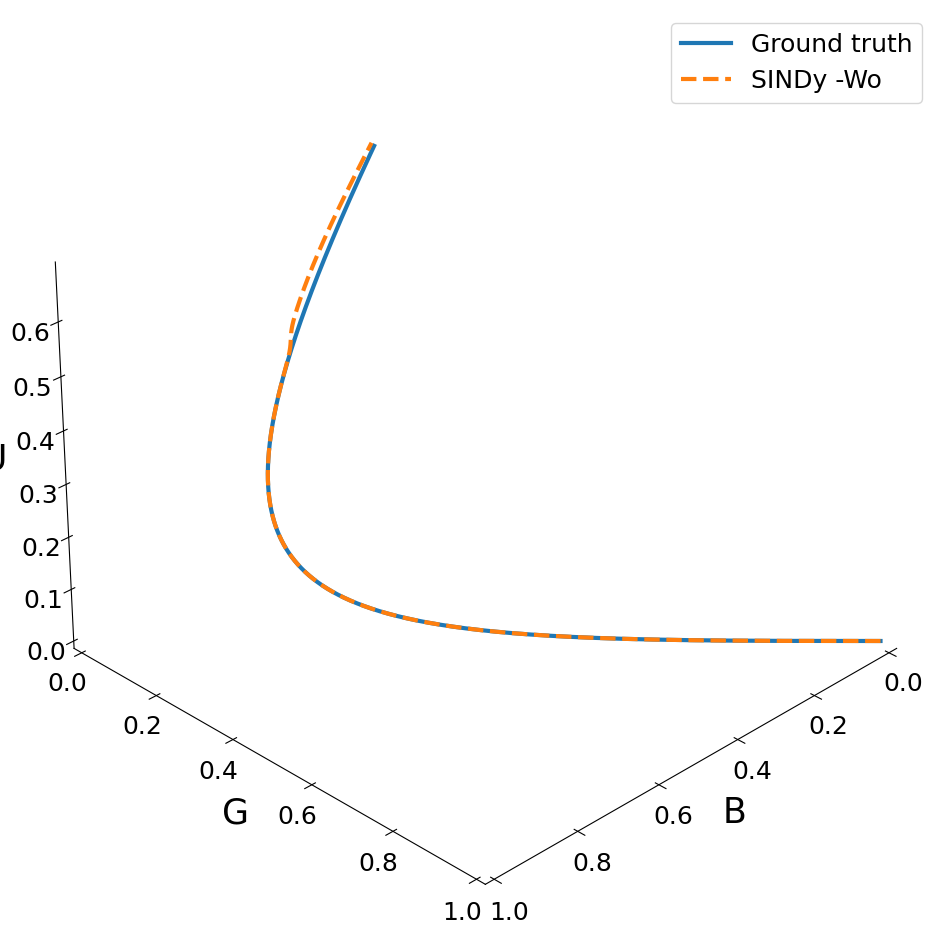

In [9]:

# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plotting the data
ax.plot(x[t<=9],  y[t<=9], z[t<=9], label="Ground truth", linewidth=3)
ax.plot(x1[t<=9], y1[t<=9], z1[t<=9], label="SINDy -Wo", linestyle='--', linewidth=3)


# Adding the legend
ax.legend()

# Setting labels with Times New Roman font
ax.set_xlabel("B", labelpad=8, fontsize = 25)
ax.set_ylabel("G", labelpad=8, fontsize = 25)
ax.set_zlabel("U", labelpad=8, fontsize = 25)


# Set limits for x and y axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylim(0, 1)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('Comparison(SINDY-Wo).jpeg', dpi = 1200)

# Display plot
plt.show()

In [10]:
print(np.linalg.norm(x1_t - x_t, ord=2) / x.size)

8.035193217437678e-05
